In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.signal import find_peaks  # 导入 find_peaks 函数

# 设置文件夹路径和特征列表
folder_path = './data_day_4'

In [2]:
# 定义特征提取函数
def extract_time_series_features(df):
    # 基本统计特征 --均值 中位数 标准差 最值 偏度 峰度
    basic_stats = df.describe().T
    
    # 时序形状特征
    autocorrelation = df['Discharge'].autocorr() # 自相关性
    trend = np.polyfit(np.arange(len(df)), df['Discharge'], 1)[0] # 趋势
    
    # 动态特征
    rolling_mean = df['Discharge'].rolling(window=7).mean() # 滚动均值
    rolling_std = df['Discharge'].rolling(window=7).std() # 滚动标准差
    
    # 季节性特征
    seasonal_component = df['Discharge'] - rolling_mean # 季节分量

    # 气象关联特征
    correlation = df['Discharge'].corr(df['Prcp']) # 与降雨量的相关系数
    lagged_correlation = df['Discharge'].corr(df['Prcp'].shift(1)) # 与降水量的滞后相关系数
    
    # 构建特征向量
    features = {
        'mean': basic_stats['mean']['Discharge'],  # 均值 中心趋势
        'median': basic_stats['50%']['Discharge'], # 中位数 中心位置（异常值不敏感）
        'std': basic_stats['std']['Discharge'], # 标准差 离散程度
        'skewness': df['Discharge'].skew(),     # 偏度 对称性
        'kurtosis': df['Discharge'].kurtosis(), # 峰值 尖峰程度
        'autocorrelation': autocorrelation,     # 自相关性 周期性
        'trend': trend,                         # 趋势
        'rolling_mean': rolling_mean.mean(),      # 滚动均值（滑动窗口平均值）
        'rolling_std': rolling_std.mean(),        # 滚动标准差（滑动窗口标准差）
        'seasonal_component': seasonal_component.mean(), # 季节性变化
        'correlation_results': correlation, 
        'lagged_correlation': lagged_correlation,  # 气象关联特征
    }
    
    return features

In [3]:
# 读取所有CSV文件
data = []
file_names = []

# 读取所有CSV文件
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        # 提取时序特征
        features = extract_time_series_features(df)
        data.append(features)
        file_names.append(file_name)

In [4]:
# 将特征值输出到文件中
df_features = pd.DataFrame(data, index=file_names)
df_features.to_csv("time_series_features.csv")

In [5]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

all_data = pd.read_csv("time_series_features.csv")
id_list= all_data.iloc[:,:1]
all_data = all_data.iloc[:,1:]

# 处理缺失值（如果有）
all_data.dropna(inplace=True)

# 特征选择 - 方差阈值选择
selector = VarianceThreshold()
selected_data = selector.fit_transform(all_data)

# 标准化特征
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data)

In [6]:
# 使用主成分分析（PCA）进行特征组合
pca = PCA(n_components=0.95)  # 保留95%的方差
combined_data = pca.fit_transform(scaled_data)

In [7]:
print(len(combined_data[0]))

5


In [8]:
# 确定最优聚类数目
sse = []
silhouette_scores = []
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(combined_data)
    sse.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(combined_data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

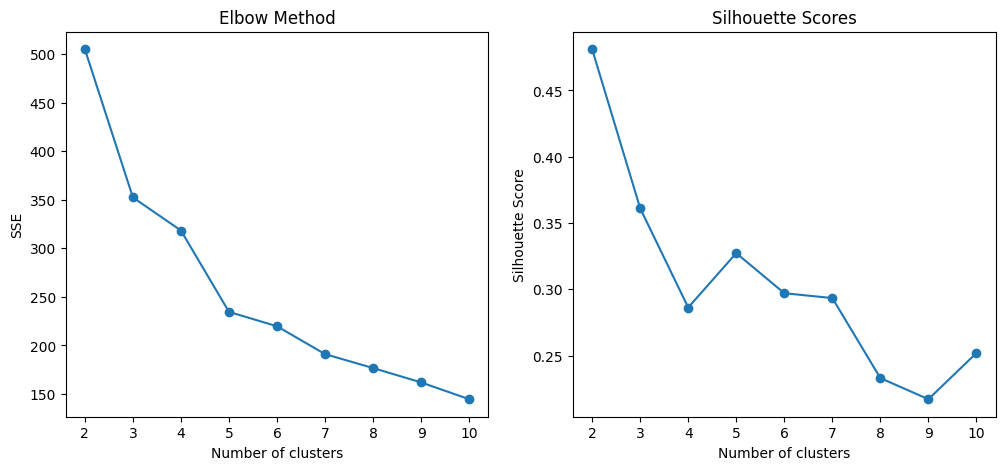

In [9]:
# 绘制肘部法图和轮廓系数图
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [10]:
# 选择最优的聚类数目
optimal_clusters = 5

# 进行最终聚类
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(combined_data)

cluster_labels = kmeans.labels_

In [11]:
# 创建 DataFrame
df = pd.DataFrame({'Filename': id_list['Watershed_ID'], 'Cluster_ID': cluster_labels})

# 将 DataFrame 写入 CSV 文件
df.to_csv('cluster_results.csv', index=False)

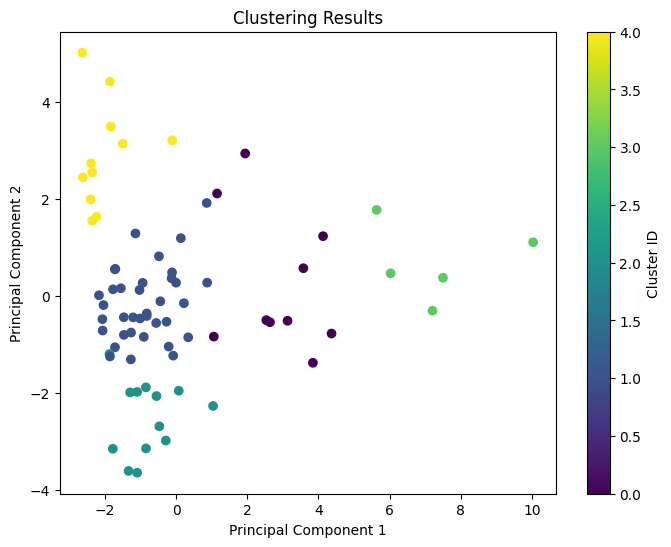

In [12]:
from sklearn.decomposition import PCA

# 使用PCA将数据降到二维
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# 绘制聚类结果的散点图
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster ID')
plt.show()
